In [264]:
# Import Libraries
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
from lazypredict.Supervised import LazyRegressor
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as ltb
from sklearn.metrics import r2_score, accuracy_score, f1_score, precision_score, recall_score, roc_curve, classification_report
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [265]:
df=pd.read_csv("Interview_Dataset.csv")
df.set_index("ID",inplace=True)

In [266]:
# Lets see our data set
df

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
ID,,,,,,,,
462809,Male,No,22,No,Healthcare,1.00,Low,4.00
462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.00
466315,Female,Yes,67,Yes,Engineer,1.00,Low,1.00
461735,Male,Yes,67,Yes,Lawyer,0.00,High,2.00
462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.00
...,...,...,...,...,...,...,...,...
464018,Male,No,22,No,NaN,0.00,Low,7.00
464685,Male,No,35,No,Executive,3.00,Low,4.00
465406,Female,No,33,Yes,Healthcare,1.00,Low,1.00


In [267]:
# Chechking columns 
df.dtypes.value_counts()

object     5
float64    2
int64      1
dtype: int64

In [268]:
df.isna().sum()

Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
dtype: int64

In [269]:
# Profile Report
profile = ProfileReport(df, title="Profiling Report")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [270]:
# We have 806 duplicate rows
# Fill Values, Drop Missing and Duplicate Values
df['Family_Size']=df.Family_Size.fillna(np.nanmedian(df.Family_Size))
df=df.drop_duplicates().dropna()
df

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
ID,,,,,,,,
462809,Male,No,22,No,Healthcare,1.00,Low,4.00
466315,Female,Yes,67,Yes,Engineer,1.00,Low,1.00
461735,Male,Yes,67,Yes,Lawyer,0.00,High,2.00
461319,Male,Yes,56,No,Artist,0.00,Average,2.00
460156,Male,No,32,Yes,Healthcare,1.00,Low,3.00
...,...,...,...,...,...,...,...,...
460132,Male,No,39,Yes,Healthcare,3.00,Low,2.00
463613,Female,Yes,48,Yes,Artist,0.00,Average,6.00
463002,Male,Yes,41,Yes,Artist,0.00,High,5.00


In [271]:
df.columns[df.dtypes=='object']

Index(['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score'], dtype='object')

In [272]:
# Dummy Variables
df['Gender']=pd.get_dummies(df.Gender)['Male']
df['Ever_Married']=pd.get_dummies(df.Ever_Married)['Yes']
df['Graduated']=pd.get_dummies(df.Graduated)['No']
df[pd.get_dummies(df.Profession).columns]=pd.get_dummies(df.Profession)
df.drop(columns=["Profession"],inplace=True)
df[pd.get_dummies(df.Spending_Score).columns]=pd.get_dummies(df.Spending_Score)
df.drop(columns=["Spending_Score"],inplace=True)
df.drop(columns=["High","Average"],inplace=True)
df.Low.replace({0:1,1:0}, inplace=True)
df.rename(columns={"Low":"Salary"}, inplace=True)
df['Work_Experience'] = np.where(df['Work_Experience'] >= 1,1,0)

In [273]:
df.dtypes.value_counts()

uint8      13
int64       1
int32       1
float64     1
dtype: int64

In [274]:
df

,Gender,Ever_Married,Age,Graduated,Work_Experience,Family_Size,Artist,Doctor,Engineer,Entertainment,Executive,Healthcare,Homemaker,Lawyer,Marketing,Salary
ID,,,,,,,,,,,,,,,,
462809,1,0,22,1,1,4.00,0,0,0,0,0,1,0,0,0,0
466315,0,1,67,0,1,1.00,0,0,1,0,0,0,0,0,0,0
461735,1,1,67,0,0,2.00,0,0,0,0,0,0,0,1,0,1
461319,1,1,56,1,0,2.00,1,0,0,0,0,0,0,0,0,1
460156,1,0,32,0,1,3.00,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460132,1,0,39,0,1,2.00,0,0,0,0,0,1,0,0,0,0
463613,0,1,48,0,0,6.00,1,0,0,0,0,0,0,0,0,1
463002,1,1,41,0,0,5.00,1,0,0,0,0,0,0,0,0,1


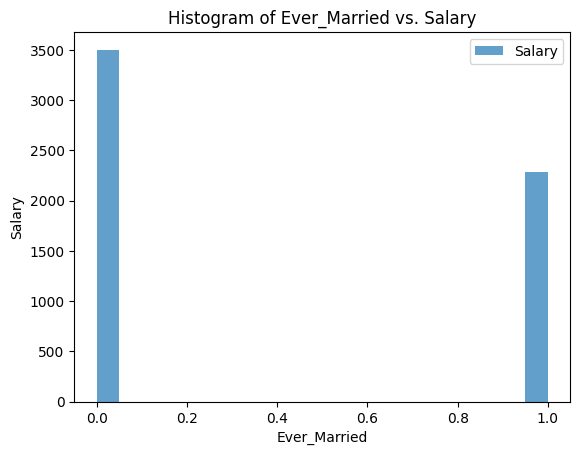

In [275]:
# Visualization
# As seen in the graph, the salary of individuals who have never been married is higher.
df.plot.hist(x='Ever_Married', y='Salary', bins=20, alpha=0.7)
plt.xlabel("Ever_Married")
plt.ylabel('Salary')
plt.title(f'Histogram of Ever_Married vs. Salary')
plt.show()

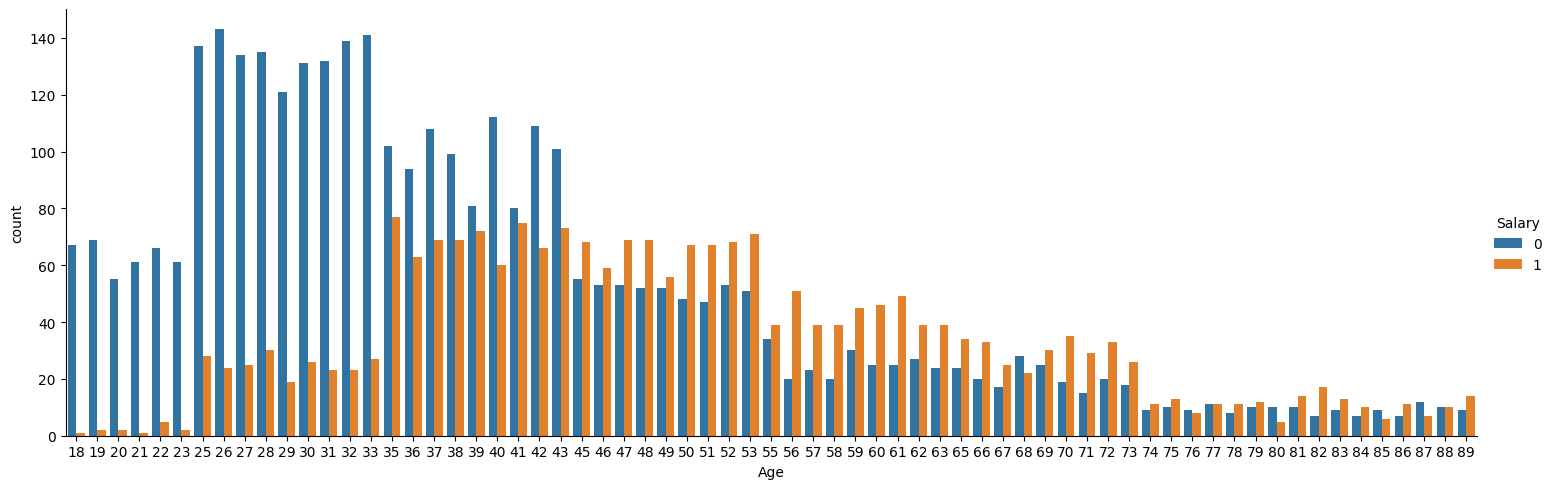

In [276]:
# At younger ages, salaries are low, but as age increases, salaries also show an increase.
sns.catplot(x="Age",kind="count",data=df,hue="Salary",aspect=3)

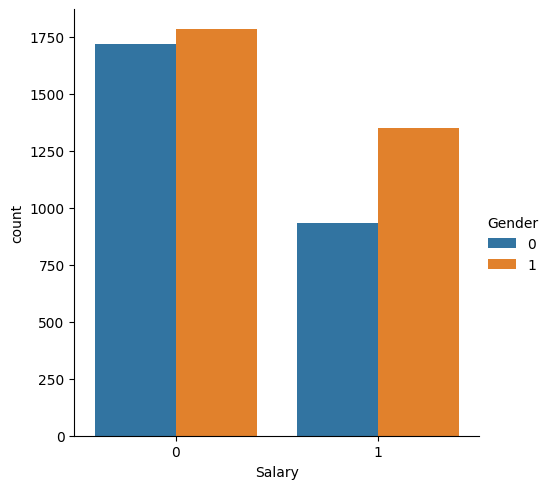

In [277]:
# Gender 1 Male 0 Female
# High-salary earning men earn more than high-salary earning women.
# The number of low-salary earners is higher than the number of high-salary earners
sns.catplot(x="Salary",kind="count",data=df,hue="Gender")

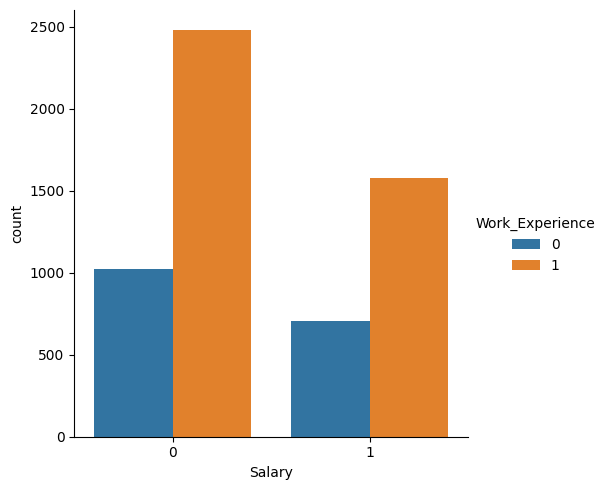

In [278]:
sns.catplot(x="Salary",kind="count",data=df,hue="Work_Experience")

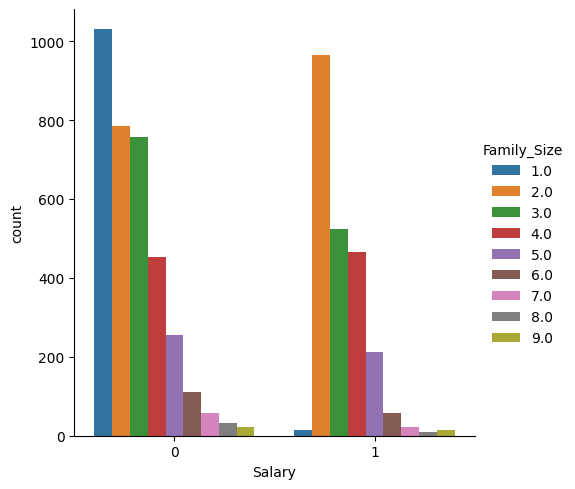

In [279]:
sns.catplot(x="Salary",kind="count",data=df,hue="Family_Size")

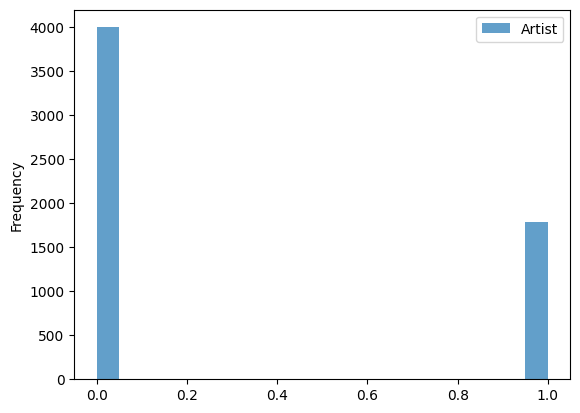

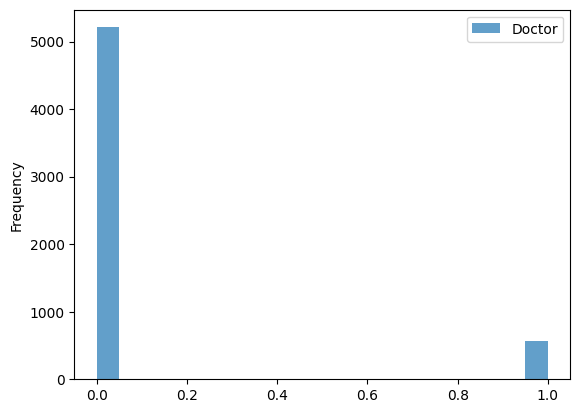

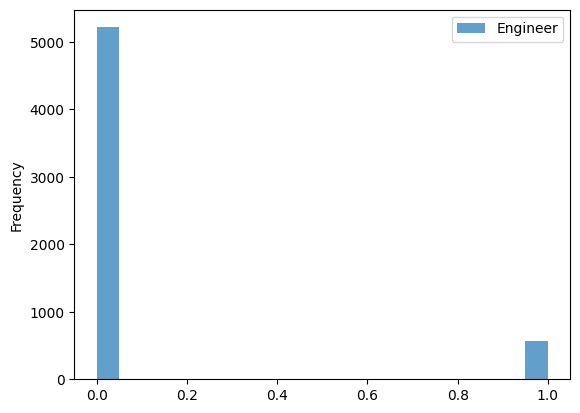

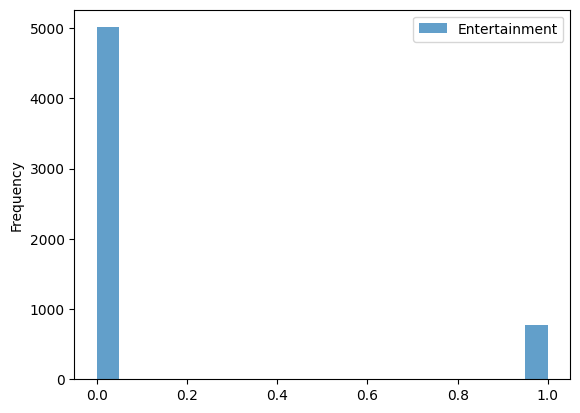

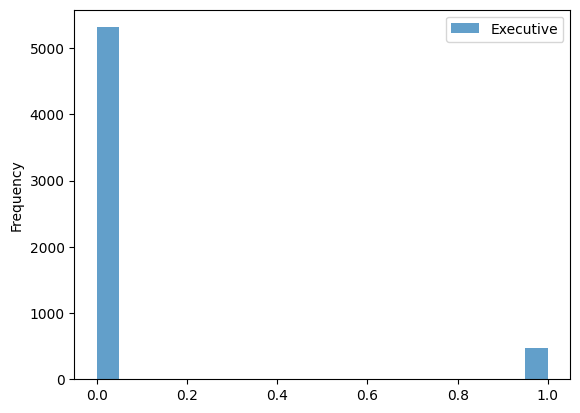

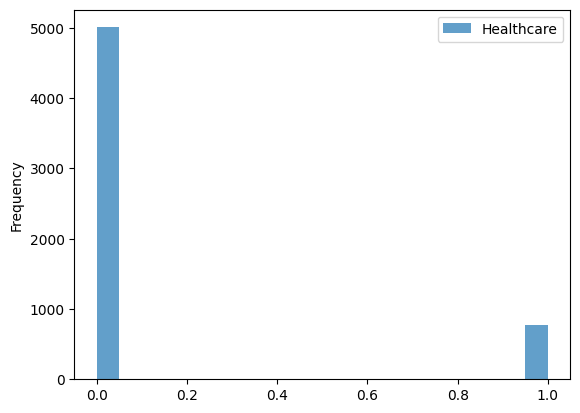

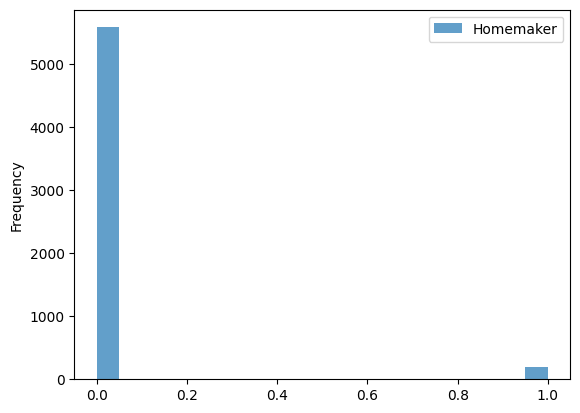

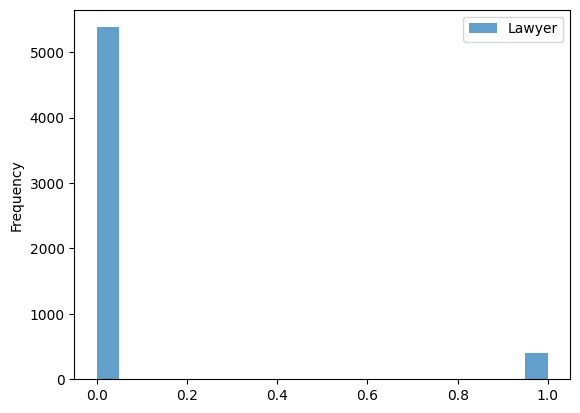

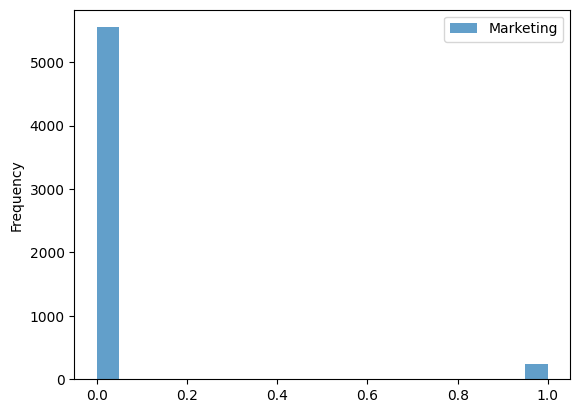

In [304]:
for i in df.columns[6:15]:
    %matplotlib inline
    df.plot.hist(x='Salary', y=i, bins=20, alpha=0.7)
    plt.show()

Text(0.5, 1.0, 'Salary Graphic')

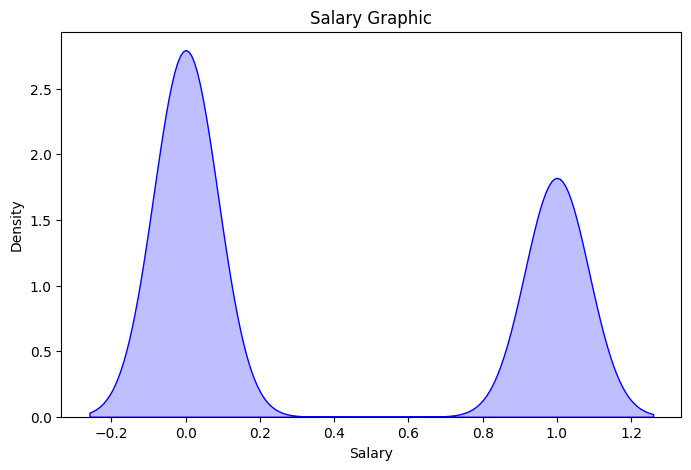

In [281]:
plt.figure(figsize=(8,5))
aw=sns.kdeplot(df["Salary"],color="blue",shade=True)
aw.set_title("Salary Graphic")

<AxesSubplot: >

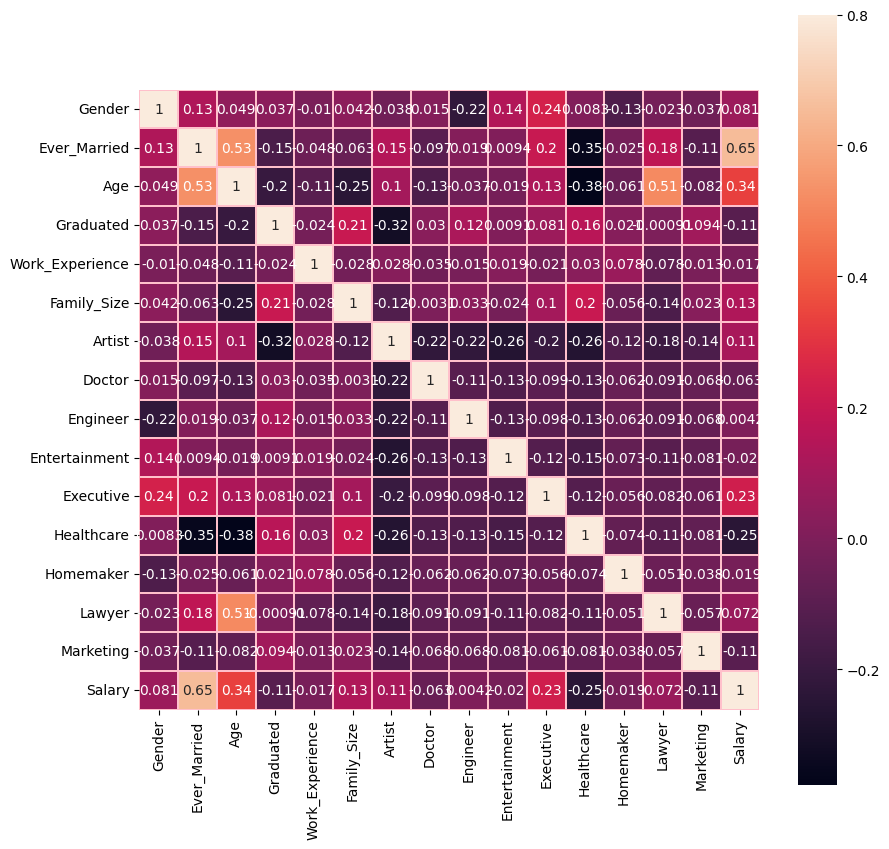

In [292]:
# Correlation Map
corr=df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, vmax=.8, linewidths=0.05,square=True,annot=True,linecolor="pink")

In [ ]:
# Choosing Model from Lazy Predict
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='Salary')[:2000], df.Salary[:2000], test_size=0.10, random_state=42)
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
models,predictions = reg.fit(X_train, X_test, y_train, y_test)

  0%|          | 0/42 [00:00<?, ?it/s]

 17%|█▋        | 7/42 [00:00<00:01, 32.95it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


100%|██████████| 42/42 [01:10<00:00,  1.67s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 129
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 15
[LightGBM] [Info] Start training from score 0.383333


In [ ]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.59,0.62,0.31,0.19
HistGradientBoostingRegressor,0.53,0.57,0.32,0.40
LGBMRegressor,0.53,0.57,0.32,0.05
AdaBoostRegressor,0.53,0.56,0.33,0.04
RandomForestRegressor,0.52,0.56,0.33,0.41
SVR,0.48,0.52,0.34,0.11
MLPRegressor,0.48,0.52,0.34,1.60
NuSVR,0.47,0.51,0.35,0.21
SGDRegressor,0.46,0.50,0.35,0.01


In [ ]:
# LGBMRegressor
model = ltb.LGBMRegressor()
model.fit(X_train, y_train)
pred=model.predict(X_test)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 116
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 15
[LightGBM] [Info] Start training from score 0.383333


In [ ]:
#r2 score LGBMRegressor
r2_score(y_test,pred)

0.5671723843730667

In [ ]:
# LGBMClassifier
model = ltb.LGBMClassifier()
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 690, number of negative: 1110
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 116
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383333 -> initscore=-0.475424
[LightGBM] [Info] Start training from score -0.475424


LGBMClassifier()

In [ ]:
# Accuracy_score LGBMClassifier
pred=model.predict(X_test)
accuracy_score(y_test,pred)

0.855

In [ ]:
# F1_score LGBMClassifier
f1_score(y_test, pred)

0.8304093567251462

In [ ]:
# Precision_score LGBMClassifier
precision_score(y_test, pred)

0.8068181818181818

In [ ]:
# Recall_score LGBMClassifier
recall_score(y_test, pred)

0.8554216867469879

In [ ]:
# roc_curve LGBMClassifier
roc_curve(y_test, pred)

(array([0.        , 0.14529915, 1.        ]),
 array([0.        , 0.85542169, 1.        ]),
 array([inf,  1.,  0.]))

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87       117
           1       0.81      0.86      0.83        83

    accuracy                           0.85       200
   macro avg       0.85      0.86      0.85       200
weighted avg       0.86      0.85      0.86       200



In [ ]:
# Parametre optimize
num_leaves=[2,5,50]
learning_rate=[0.1,0.001]
n_estimators=[100, 1000]
for i in num_leaves:
  for j in learning_rate:
    for f in n_estimators:
      model = ltb.LGBMClassifier(num_leaves=i, learning_rate=j, n_estimators=f)
      model.fit(X_train, y_train)
      pred=model.predict(X_test)
      print("Accuracy=", accuracy_score(y_test,pred), "Num of Leaves=", i, "Learning Rate=", j, "N Estimator=", f)

[LightGBM] [Info] Number of positive: 690, number of negative: 1110
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 116
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383333 -> initscore=-0.475424
[LightGBM] [Info] Start training from score -0.475424
Accuracy= 0.89 Num of Leaves= 2 Learning Rate= 0.1 N Estimator= 100
[LightGBM] [Info] Number of positive: 690, number of negative: 1110
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 116
[LightGBM] [Info] Number of data points in the

In [ ]:
# Hyperparameter Tuning
#param_grid = {
    #'num_leaves': [31, 127],
    #'reg_alpha': [0.1, 0.5],
    #'min_data_in_leaf': [30, 50, 100, 300, 400],
    #'lambda_l1': [0, 1, 1.5],
    #'lambda_l2': [0, 1]
    #}

#lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt',  objective='binary', num_boost_round=2000, learning_rate=0.1, metric='auc')

#gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv=3)
#lgb_model = gsearch.fit(X=X_train, y=y_train)

#print(lgb_model.best_params_, lgb_model.best_score_)

In [ ]:
#lgb_model.best_params_

In [ ]:
#pred=lgb_model.predict(X_test)
#accuracy_score(y_test, pred)

In [ ]:
# DecisionTreeClassifier
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='Salary')[:2000], df.Salary[:2000], test_size=0.10, random_state=42)
model=DecisionTreeClassifier()
model.fit(X_train,y_train)

DecisionTreeClassifier()

In [ ]:
model.score(X_test,y_test)

0.83

In [ ]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86       117
           1       0.84      0.73      0.78        83

    accuracy                           0.83       200
   macro avg       0.83      0.82      0.82       200
weighted avg       0.83      0.83      0.83       200

